In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [4]:
A,D = 1.0,1.0
delta_t_list=np.linspace(0.01,2,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))

In [5]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

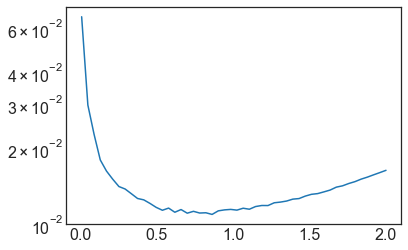

In [6]:
plt.semilogy(delta_t_list,result_Bayes_array.T[3])

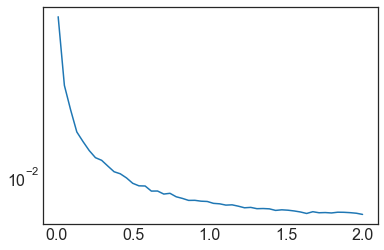

In [7]:
plt.semilogy(delta_t_list,result_Bayes_array.T[1])

In [23]:
A,D = 1.0,1.0
tau_real = A/D
delta_t_list=np.linspace(0.01,2,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))
pick_delta = 7
print(delta_t_list[pick_delta])
data = langevin.time_series(A=A, D=D, delta_t=delta_t_list[pick_delta], N=N)

0.2942857142857143


In [9]:
# compile model for reuse
sm = lcm.OU_DA()
sm.samples=20000

In [10]:
trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t_list[pick_delta],
                N=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1857.15draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.886032086087769, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c257dfe48>,
      dtype=object)

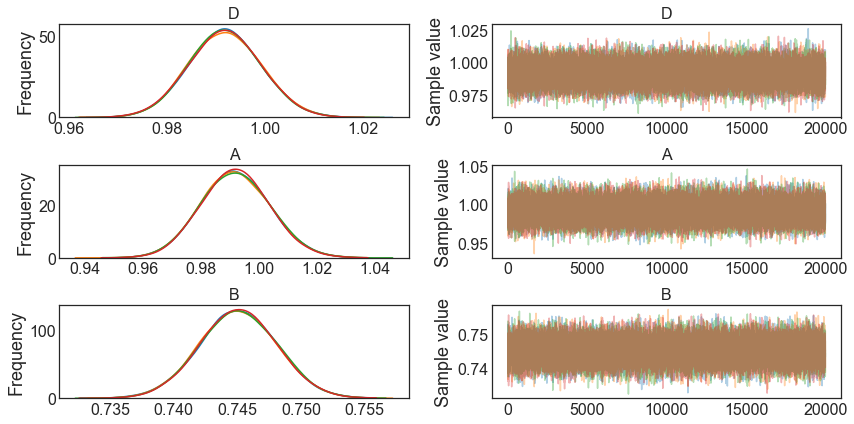

In [11]:
pm.traceplot(trace)

In [12]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t,
                N=50000)
    a_mean = trace['A'].mean()
    d_mean = trace['D'].mean()
    a_std = trace['A'].std()
    d_std = trace['D'].std()
    results = [a_mean,a_std,d_mean,d_std]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.01


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1794.31draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8826748568709732, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8938960266514889, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.05061224489795919


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1918.13draws/s]
The acceptance probability does not match the target. It is 0.8815351488186761, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802835891622699, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.09122448979591836


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1800.35draws/s]
The acceptance probability does not match the target. It is 0.8842830431241216, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.13183673469387755


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1862.79draws/s]
The acceptance probability does not match the target. It is 0.8947851608362186, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928646312773797, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.17244897959183675


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1838.01draws/s]
The acceptance probability does not match the target. It is 0.8918080758671748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8811395539895426, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.21306122448979592


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1890.76draws/s]
The acceptance probability does not match the target. It is 0.8822686127156005, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796254612696641, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.2536734693877551


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1814.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.2942857142857143


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1786.66draws/s]
The acceptance probability does not match the target. It is 0.8804486763115518, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.3348979591836735


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1857.11draws/s]
The acceptance probability does not match the target. It is 0.8795427271178607, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847146148623617, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885524110773979, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.37551020408163266


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1858.71draws/s]
The acceptance probability does not match the target. It is 0.879104355335829, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8789147348406534, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.41612244897959183


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1813.11draws/s]
The acceptance probability does not match the target. It is 0.8790718083914748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870714688296176, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810590829761163, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.45673469387755106


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:42<00:00, 1936.53draws/s]


0.49734693877551023


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1773.70draws/s]
The acceptance probability does not match the target. It is 0.8953068150538902, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8787772404234545, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5379591836734694


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1784.26draws/s]
The acceptance probability does not match the target. It is 0.8934798161148174, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882859798781049, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853261168265862, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804483425028008, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5785714285714286


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1829.79draws/s]
The acceptance probability does not match the target. It is 0.8795722625391647, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8940067665913, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.6191836734693877


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1863.16draws/s]
The acceptance probability does not match the target. It is 0.8813188092069592, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802075790489131, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805955912674813, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.659795918367347


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:47<00:00, 1739.47draws/s]
The acceptance probability does not match the target. It is 0.8912215307362338, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889682655680201, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7004081632653062


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1831.25draws/s]
The acceptance probability does not match the target. It is 0.8856564998638572, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849465518107623, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8797885182603493, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8848220803368642, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7410204081632653


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1809.50draws/s]
The acceptance probability does not match the target. It is 0.8830278387822307, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838264711991729, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7816326530612245


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1869.95draws/s]
The acceptance probability does not match the target. It is 0.8815933460774757, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8222448979591837


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1796.49draws/s]
The acceptance probability does not match the target. It is 0.8884859218563219, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8628571428571429


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:48<00:00, 1694.18draws/s]
The acceptance probability does not match the target. It is 0.8857567481285676, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927193487234385, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8877971181567805, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9034693877551021


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1846.38draws/s]
The acceptance probability does not match the target. It is 0.8827214070768692, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9440816326530612


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1789.91draws/s]
The acceptance probability does not match the target. It is 0.8788945436860265, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837830229516024, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882683422829034, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9846938775510204


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:47<00:00, 1732.66draws/s]
The acceptance probability does not match the target. It is 0.8872606216207359, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.0253061224489797


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1832.22draws/s]
The acceptance probability does not match the target. It is 0.8789398214524516, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.0659183673469388


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:47<00:00, 1717.91draws/s]
The acceptance probability does not match the target. It is 0.8913181620864337, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929618234172252, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892091932339527, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.106530612244898


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1807.53draws/s]
The acceptance probability does not match the target. It is 0.8843826977922195, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.1471428571428572


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1775.98draws/s]
The acceptance probability does not match the target. It is 0.8869192316381049, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836417511646909, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.1877551020408164


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1823.50draws/s]
The acceptance probability does not match the target. It is 0.8824182215171984, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.2283673469387755


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:47<00:00, 1738.90draws/s]
The acceptance probability does not match the target. It is 0.8795074349616813, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.2689795918367348


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [01:02<00:00, 1304.10draws/s]
The acceptance probability does not match the target. It is 0.8920436732302209, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.921535298858982, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.309591836734694


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:48<00:00, 1700.08draws/s]
The acceptance probability does not match the target. It is 0.8972198017648448, but should be close to 0.8. Try to increase the number of tuning steps.


1.350204081632653


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1785.20draws/s]
The acceptance probability does not match the target. It is 0.8804979221798133, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.3908163265306124


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1796.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.4314285714285715


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1758.50draws/s]
The acceptance probability does not match the target. It is 0.8803881607933576, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794833707427989, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868069093171522, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.4720408163265306


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1766.78draws/s]
The acceptance probability does not match the target. It is 0.8807224692157222, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8851806912049615, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.51265306122449


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1826.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.553265306122449


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:48<00:00, 1705.54draws/s]
The acceptance probability does not match the target. It is 0.8801335416794411, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8931068307073986, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888663746696459, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.5938775510204082


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:58<00:00, 1400.93draws/s]
The acceptance probability does not match the target. It is 0.8835819699227088, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9177589255354339, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.6344897959183673


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1826.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.6751020408163266


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:47<00:00, 1721.16draws/s]
The acceptance probability does not match the target. It is 0.88031188420748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795005770659349, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862917913475704, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.7157142857142857


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:47<00:00, 1714.33draws/s]
The acceptance probability does not match the target. It is 0.8909685884594949, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793194259517114, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.7563265306122449


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1824.78draws/s]
The acceptance probability does not match the target. It is 0.8796025261653232, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8798660389647025, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.7969387755102042


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:46<00:00, 1753.70draws/s]
The acceptance probability does not match the target. It is 0.8820680232972543, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892231505004656, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.8375510204081633


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:45<00:00, 1801.79draws/s]
The acceptance probability does not match the target. It is 0.8793734981849716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880465102240317, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.8781632653061224


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1870.46draws/s]
The acceptance probability does not match the target. It is 0.880992524588581, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.9187755102040818


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [01:00<00:00, 1347.64draws/s]
The acceptance probability does not match the target. It is 0.8814166320058603, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8874771544368507, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9247512080027261, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.9593877551020409


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:43<00:00, 1890.10draws/s]
The acceptance probability does not match the target. It is 0.8814973326608004, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8841036291303593, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


2.0


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:44<00:00, 1853.09draws/s]
The acceptance probability does not match the target. It is 0.8827227335978447, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859551154894644, but should be close to 0.8. Try to increase the number of tuning steps.


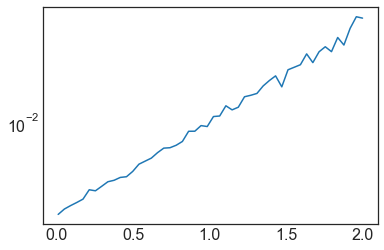

In [13]:
plt.semilogy(delta_t_list,result_array.T[3])

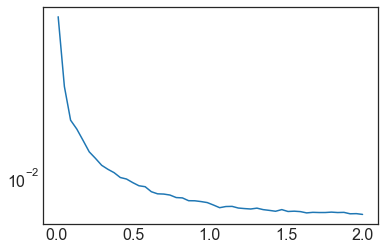

In [14]:
plt.semilogy(delta_t_list,result_array.T[1])

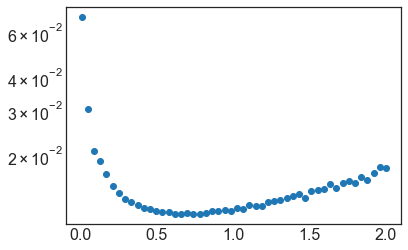

In [16]:
dtau = np.sqrt(result_array.T[1]**2+result_array.T[3]**2)
plt.semilogy(delta_t_list,dtau,"o")

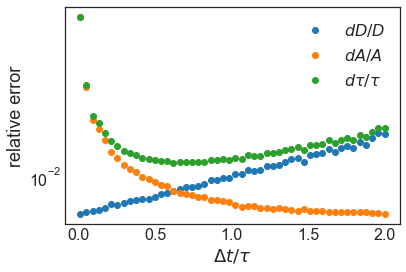

In [20]:
plt.semilogy(delta_t_list,result_array.T[3],"o",label=r"$dD/D$")
plt.semilogy(delta_t_list,result_array.T[1],"o",label=r'$dA/A$')
plt.semilogy(delta_t_list,dtau,"o",label=r'$d\tau/\tau$')
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend()

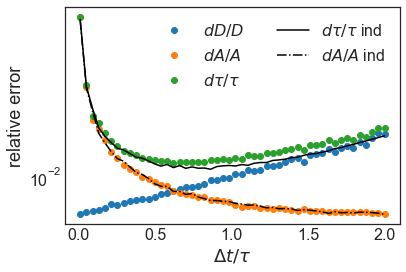

In [30]:
plt.semilogy(delta_t_list,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list,result_array.T[1]/A,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.semilogy(delta_t_list,result_Bayes_array.T[3]/tau_real,color="k",label=r"$d\tau/\tau$ ind")
plt.semilogy(delta_t_list,result_Bayes_array.T[1]/A,"-.",color="k",label=r"$dA/A$ ind")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend(ncol=2)
plt.savefig("optimaldt_1_1.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")